# Data Analytics of Historical Stock Prices
#### *_Data Engineering Capstone Project_*

### Project Summary
This project is to capture the Historical Stock prices of US stocks and Stock fundamentals and create a data pipeline to load the data into Dimension and Fact tables which will enable to do stock analytics. The goal is to create Stock analytics table which can give us various statistics about each stock using which investment and trading decisions can be made. 

### Scope of Project
* Capture Historical stock data
* Define a data model
* Create Dimension & Fact models based on star schema design
* Create Data Pipeline to load the Dimension and Facts
* Perform Analytics to provide Analytical Insights on the Stock data

### Import the necessary packages

In [2]:
# Do all imports and installs here
import pandas as pd
import datetime
from pyspark.sql.functions import year, month, dayofmonth, col
import configparser
import os
from IPython.display import Image
import matplotlib.pyplot as plt

### Setup AWS Credentials
  * AWS Access key and Secret Access key are set in a config file `dl.cfg` (In general *.cfg).
  * **Note** : This file will not be checked in git (or) the values cannot be shared. Keep a note to assign your own keys in this file before running this code

In [4]:
config = configparser.ConfigParser()
config.read('dl.cfg')
os.environ['AWS_ACCESS_KEY_ID']=config['AWS_CREDENTIALS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS_CREDENTIALS']['AWS_SECRET_ACCESS_KEY']

### Initiate Spark Session

In [5]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
config("spark.jars.packages","org.apache.hadoop:hadoop-aws:2.7.0")\
.enableHiveSupport().getOrCreate()

### Datasets


##### Following datasets are used in this project:
* `**Historical Stock Prices data**`
    * *Description* :  This dataset contains the Historical Stock Prices of US Stocks.
    * *Data Range*  : This data is available for a period ranging from 1970 till 2018
    * *Data Frequency* : Daily
    * *Data format* : csv file (delmited by Comma)
    * *Size* : 2 GB
    * *Number of records* : 21 Million rows
    * *Dataset Source* : https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018
    

* `**Stock Fundamentals data**`
    * *Description* :  This dataset contains the US stock fundamental paremers such as Revenues, EBITDA, Liabilities etc.
    * *Data Range*  : This data is available for a period ranging from 2008 till 2016
    * *Data Frequency* : Every Quarter
    * *Data format* : csv file (delmited by semicolon)
    * *Size* : 105 MB
    * *Number of records* : 1.95 Million rows
    * *Dataset Source* : https://simfin.com/data/access/download

    
* `**Stock list**`
    * *Description* :  This dataset contains the Ticker symbol, name and Industry descriptionof each US stock
    * *Data Range*  : This data is available for a period ranging from 1970 till 2018
    * *Data Frequency* : Static data.
    * *Data format* : JSON file
    * *Size* : 1027 KB
    * *Number of records* : 6460 rows
    * *Dataset Source* : https://www.kaggle.com/ehallmar/daily-historical-stock-prices-1970-2018


* `**SP500 Historical Returns**`
    * *Description* :  This dataset contains the Historical price of S&P500 Index
    * *Data Range*  : This data is available for a period ranging from 1970 till 2019
    * *Data Frequency* : Monthly.
    * *Data format* : JSON file
    * *Size* : 47 KB
    * *Number of records* : 599 rows
    * *Dataset Source* : https://finance.yahoo.com/quote/%5EGSPC/history/
   
   
* `**Historical GOLD price**`
    * *Description* :  This dataset contains the Gold price
    * *Data Range*  : This data is available for a period ranging from 1968 till 2019
    * *Data Frequency* : Monthly.
    * *Data format* : JSON file
    * *Size* : 108 KB
    * *Number of records* : 622 rows
    * *Dataset Source* : https://www.quandl.com/data/LBMA/GOLD-Gold-Price-London-Fixing


* `**US Unemployment Rate**`
    * *Description* :  This dataset contains the US Unemployment Rate
    * *Data Range*  : This data is available for a period ranging from 1948 till 2019
    * *Data Frequency* : Monthly.
    * *Data format* : JSON file
    * *Size* : 44 KB
    * *Number of records* : 861 rows
    * *Dataset Source* : https://www.quandl.com/data/FRED/UNRATE-Civilian-Unemployment-Rate

### Dataset location

  * The datasets mentioned above are located in AWS S3 filesystem. Additionally 2 more directories are created in S3 to hold Staging data and Target data. 
Staging tables will be stored under staging_data_path in parquet format. Dimension and Fact tables are stored under target_data_path in parquet format.

In [6]:
source_data_path = "s3a://historical-stock-analytics/source-data"
staging_data_path = "./historical-stock-analytics/staging-data"
target_data_path = "./historical-stock-analytics/target-data"

### Read the Source data - Perform Data Exploration/Data Assessment

#### Historical Stock Prices

In [7]:
df_src_stockprice=spark.read.format('csv').option("header", "true").load(os.path.join(source_data_path, 'historical_stock_prices.csv.gz'))

In [8]:
df_src_stockprice.show(2)

+------+----------------+----------------+----------------+-----+----------------+-------+----------+
|ticker|            open|           close|       adj_close|  low|            high| volume|      date|
+------+----------------+----------------+----------------+-----+----------------+-------+----------+
|   AHH|            11.5|11.5799999237061|8.49315452575684|11.25|11.6800003051758|4633900|2013-05-08|
|   AHH|11.6599998474121|11.5500001907349|8.47115135192871| 11.5|11.6599998474121| 275800|2013-05-09|
+------+----------------+----------------+----------------+-----+----------------+-------+----------+
only showing top 2 rows



In [9]:
df_src_stockprice.count()

20973889

#### Stock Fundamentals

In [10]:
df_src_stockfund=spark.read.format('csv').option("header", "true").option("delimiter", ";").load(os.path.join(source_data_path, 'stock_fundamentals.csv'))

In [11]:
df_src_stockfund.show(2)

+------+---------+------------------------------------+--------------------+----------+---------------+
|Ticker|SimFin ID|Company Industry Classification Code|      Indicator Name|      date|Indicator Value|
+------+---------+------------------------------------+--------------------+----------+---------------+
|   ABT|    63877|                              106004|Cash and Cash Equ...|2007-12-31|       2820.827|
|   ABT|    63877|                              106004|         Receivables|2007-12-31|       4946.876|
+------+---------+------------------------------------+--------------------+----------+---------------+
only showing top 2 rows



In [12]:
df_src_stockfund.count()

1943245

#### Stock List

In [13]:
df_src_stock=spark.read.json(os.path.join(source_data_path, 'historical_stocks.json'), multiLine=True)

In [14]:
df_src_stock.show(2)

+--------+--------------------+--------------------+-------+------+
|exchange|            industry|                name| sector|ticker|
+--------+--------------------+--------------------+-------+------+
|  NASDAQ|PROPERTY-CASUALTY...|1347 PROPERTY INS...|FINANCE|   PIH|
|  NASDAQ|PROPERTY-CASUALTY...|1347 PROPERTY INS...|FINANCE| PIHPP|
+--------+--------------------+--------------------+-------+------+
only showing top 2 rows



In [15]:
df_src_stock.count()

6460

#### S&P500 Historical Returns

In [16]:
df_src_sp500=spark.read.json(os.path.join(source_data_path, 'sp500_returns.json'), multiLine=True)

In [17]:
df_src_sp500.limit(2).toPandas()

,Adj Close,Close,Date,High,Low,Open,Volume
0,85.019997,85.019997,1970-01-01,94.250000,84.419998,92.059998,221090000
1,89.500000,89.500000,1970-02-01,90.330002,84.639999,85.019997,228380000


In [18]:
df_src_sp500.count()

599

#### Gold Price

In [19]:
df_src_goldprice=spark.read.json(os.path.join(source_data_path, 'gold_price.json'), multiLine=True)

In [20]:
df_src_goldprice.show(2)

+----------+---------+---------+--------+--------+--------+--------+
|      Date|EURO (AM)|EURO (PM)|GBP (AM)|GBP (PM)|USD (AM)|USD (PM)|
+----------+---------+---------+--------+--------+--------+--------+
|2019-10-31|   1365.3|  1372.28|  1225.5| 1233.14|  1500.0| 1505.85|
|2019-09-30|  1361.75|  1362.17| 1208.38| 1206.06|  1487.6|  1485.3|
+----------+---------+---------+--------+--------+--------+--------+
only showing top 2 rows



In [21]:
df_src_goldprice.count()

622

#### Unemployment Rate

In [22]:
df_src_unrate=spark.read.json(os.path.join(source_data_path, 'unemployment_rate.json'), multiLine=True)

In [23]:
df_src_unrate.show(2)

+----------+-----+
|      Date|Value|
+----------+-----+
|2019-09-01|  3.5|
|2019-08-01|  3.7|
+----------+-----+
only showing top 2 rows



In [24]:
df_src_unrate.count()

861

### Data Validation Functions

Following functions are created for various Data validation rules which are invoked while loading Staging, Dimension and Fact tables.
* Check if Table is Empty
* Check for Duplicates
* Check if value less than zero

##### Function to check if the table is empty

In [25]:
def check_if_table_empty(table_data, table_name):
    '''
    Function to check if the given table is empty. Throws Valueerror is zero rows found
    '''
    import inspect
    func_name = inspect.currentframe().f_code.co_name
    
    print(f"** Running Data Validation rule - {func_name}..")
    print(f"Table name = {table_name}")
    
    row_count = table_data.count()
    if row_count > 0:
        msg = f"** Data Validation rule - {func_name} - PASSED. Table contains {row_count} rows"
    else:
        msg = f"** Data Validation rule - {func_name} - FAILED. Table contains {row_count} rows"
        raise ValueError(msg)
    print(msg)

##### Function to check for duplicate values

In [26]:
def check_duplicates(table_data, table_name, column_name):
    '''
    Function to check if there are any duplicates for the given table and column. Throws Valueerror is duplicates found
    '''
    import inspect
    func_name = inspect.currentframe().f_code.co_name
    
    column_string = ", ".join(column_name)
    
    print(f"** Running Data Validation rule - {func_name}..")
    print(f"Table name = {table_name}")
    print(f"Column name = {column_string}")
    
    table_data.createOrReplaceTempView("table_view")
    row_count = spark.sql(f"select {column_string} from table_view group by {column_string} having count(*) > 1").count()

    if row_count == 0:
        msg = f"** Data Validation rule - {func_name} - PASSED. Table contains {row_count} duplicate records"
    else:
        msg = f"** Data Validation rule - {func_name} - FAILED. Table contains {row_count} duplicate records"
        raise ValueError(msg)
    
    print(msg)

##### Function to check if the value is less than zero

In [27]:
def check_if_less_than_zero(table_data, table_name, column_name):
    '''
    Function to check if there are any records with value less than zero for the given table and column. . Throws Valueerror is such vlaues found
    '''
    import inspect
    func_name = inspect.currentframe().f_code.co_name
    
    print(f"** Running Data Validation rule - {func_name}..")
    print(f"Table name = {table_name}")
    print(f"Column name = {column_name}")
    
    row_count = table_data.filter(table_data[f'{column_name}'] < 0).count()
    if row_count > 0:
        msg = f"** Completed Data Validation rule - {func_name} - FAILED. {row_count} records found with value less than zero for column {column_name}."
        raise ValueError(msg)
    else:
        msg = f"** Completed Data Validation rule - {func_name} - PASSED. No values found to be less than zero for column {column_name}."
    print(msg)

### Data preparation - Staging data
* **Data Cleansing**
  * Convert Ticker symbols to Upper name to avoid inconistencies while joining between datasets
  * Trim whitespaces around Ticker symbols, Indicator Names
  * Convert date values from String datatype to Date datatype
  * Add year and month columns so that partitioning can be done while writing into parquet format.
  
  
* **Staging of Source data into Parquet files**
  * For Historical Stock Price dataset and Stock Fundamental dataset, Partition the data by Year and Month
  * Use Write mode as `Overwrite` to truncate and load the data on every run

#### 1. Create Staging table for Stock list -- `staging_stock`

In [28]:
df_src_stock.createOrReplaceTempView("stock_view")

In [29]:
df_stg_stock = spark.sql("""
select upper(trim(Ticker)) as ticker
, trim(name) as name
, trim(industry) as industry
, trim(sector) as sector
, trim(exchange) as exchange
from stock_view
where ticker is not null 
""")

In [30]:
df_stg_stock.repartition(4).write.format("parquet").mode("overwrite").parquet(os.path.join(staging_data_path, 'staging_stock'))

In [31]:
df_stg_stock = spark.read.format("parquet").parquet(os.path.join(staging_data_path, 'staging_stock'))

In [32]:
check_if_table_empty(df_stg_stock, 'staging_stock')

** Running Data Validation rule - check_if_table_empty..
Table name = staging_stock
** Data Validation rule - check_if_table_empty - PASSED. Table contains 6460 rows


#### 2. Create Staging table for Historical Stock Prices -- `staging_stock_price`

In [33]:
df_src_stockprice.createOrReplaceTempView("stock_price_view")

In [34]:
df_stg_stockprice = spark.sql("""
select upper(trim(Ticker)) as ticker
, open
, close
, adj_close
, low 
, high
, volume
, date as period_date
, year(date) as period_year
, month(date) as period_month
from stock_price_view
where ticker is not null 
""")

##### `staging_stock_price` -- Write parquet data to S3
  * The following 3 methods of writing are tried:
    1. partition by both Year and Month
    2. partition by Year
    3. Without any explicit partition
  * On comparing the time taken, option #3 (without partitions) performed faster in both write and read operation for this dataset.
  * So this dataset will be loaded without any partitionBy clause

In [35]:
df_stg_stockprice.write.format("parquet").mode("overwrite").parquet(os.path.join(staging_data_path, 'staging_stock_price'))

##### Data Validation - Check record count to ensure the table is not empty

In [36]:
df_stg_stockprice=spark.read.parquet(os.path.join(staging_data_path, 'staging_stock_price'))

In [37]:
check_if_table_empty(df_stg_stockprice, 'staging_stock_price')

** Running Data Validation rule - check_if_table_empty..
Table name = staging_stock_price
** Data Validation rule - check_if_table_empty - PASSED. Table contains 20973889 rows


#### 3. Create Staging table for Stock Fundamentals -- `staging_stock_fundamentals`

In [38]:
df_src_stockfund.createOrReplaceTempView("stock_fund_view")

In [39]:
df_stg_stockfund = spark.sql("""
select upper(trim(Ticker)) as ticker
, trim(`Indicator Name`) as indicator_name
, `Indicator Value` as indicator_value
, date as period_date 
, year(date) as period_year
from stock_fund_view
""")

##### Write parquet data to S3

In [40]:
df_stg_stockfund.repartition(4).write.format("parquet").mode("overwrite").parquet(os.path.join(staging_data_path, 'staging_stock_fundamentals'))

##### Data Validation - Check record count to ensure the table is not empty

In [41]:
df_stg_stockfund=spark.read.parquet(os.path.join(staging_data_path, 'staging_stock_fundamentals'))

In [42]:
check_if_table_empty(df_stg_stockfund, 'staging_stock_fundamentals')

** Running Data Validation rule - check_if_table_empty..
Table name = staging_stock_fundamentals
** Data Validation rule - check_if_table_empty - PASSED. Table contains 1943245 rows


#### 4. Create Staging table for Economic indicators -- `staging_economic_indicators`

In [43]:
df_src_sp500.createOrReplaceTempView("sp500_view")
df_src_goldprice.createOrReplaceTempView("goldprice_view")
df_src_unrate.createOrReplaceTempView("unrate_view")

* All the above 3 datasets has monthly data. 
* sp500 and unemployment data uses first day of the month to denote the month value whereas Gold price data uses last day of the month.
* Since all these 3 datasets are going to be consolidated in one staging table, the dates should be consistent. 
* So, the date in gold price dataset is converted from last day to first day of the month.
  * For eg: 2000-01-01 denotes January, 2000-02-01 denotes February    

In [44]:
df_stg_econind=spark.sql("""
select s.date as period_date
, round(s.close, 2) as sp500_price
, round(g.`USD (AM)`, 2) as gold_price
, round(value, 1) as unemp_rate
from sp500_view s
left join unrate_view u
on s.date = u.date
left join goldprice_view g
on s.date = cast(date_trunc('month', g.date) as date)
where s.date between '1970-01-01' and '2019-09-01'
""")

In [45]:
df_stg_econind.repartition(4).write.format("parquet").mode("overwrite").parquet(os.path.join(staging_data_path, 'staging_economic_indicators'))

In [46]:
df_stg_econind = spark.read.format("parquet").parquet(os.path.join(staging_data_path, 'staging_economic_indicators'))

In [47]:
df_stg_econind.printSchema()

root
 |-- period_date: string (nullable = true)
 |-- sp500_price: double (nullable = true)
 |-- gold_price: double (nullable = true)
 |-- unemp_rate: double (nullable = true)



In [48]:
check_if_table_empty(df_stg_econind, 'staging_economic_indicators')

** Running Data Validation rule - check_if_table_empty..
Table name = staging_economic_indicators
** Data Validation rule - check_if_table_empty - PASSED. Table contains 597 rows


### Step 3: Data Model

#### Star Schema Model
To build a data pipeline and perform Stock Analytics, a star schema based dimensional model is chosen. The star schema consists of one or more fact tables referencing any number of dimension tables.
The star schema separates business process data into facts, which hold the measurable, quantitative data about a business, and dimensions which are descriptive attributes related to fact data.

##### Benefits of Star Schema:

The benefits of star schema denormalization are:

  * Simpler queries – star schema join logic is generally simpler than the join logic required to retrieve data from a highly normalized transactional schema.
  * Simplified business reporting logic – when compared to highly normalized schemas, the star schema simplifies common business reporting logic, such as period-over-period and as-of reporting.
  * Query performance gains – star schemas can provide performance enhancements for read-only reporting applications when compared to highly normalized schemas.
  * Fast aggregations – the simpler queries against a star schema can result in improved performance for aggregation operations.
  * Feeding cubes – star schemas are used by all OLAP systems to build proprietary OLAP cubes efficiently; in fact, most major OLAP systems provide a ROLAP mode of operation which can use a star schema directly as a source without building a proprietary cube structure.
  
  
#### Dimension tables
Dimension tables usually have a relatively small number of records compared to fact tables, but each record may have a very large number of attributes to describe the fact data.  Dimensional attributes help to describe the dimensional value. They are normally descriptive, textual values. 

In this `Stock Analytics`, following dimension tables are designed.

* **Date Dimension**
  * All the staging tables used in this project have date based on a time period. For eg: Stock price for every day, Stock fundamentals of every quarter, Economic Indicators of every month. So designing a date dimension table is very essential so that Analysts can derive some useful analytics based on any time frame.
  * Date Dimension has following columns: (For column description, please refer the Data Dictionary)
    * *Date*
    * *Year*
    * *Month*
    * *Day*
    * *Week*
    * *Quarter*
    * *Weekday*
    * *Weekday_name*
    * *Load_ts*
    
    
* **Stock Dimension**
  * Stock Dimension table is designed to store descriptive attributes of each stock such as Stock name, Industry, Sector, Exchange.
  * Stock Dimension has following columns: (For column description, please refer the Data Dictionary)
    * *Ticker*
    * *Name*
    * *Industry*
    * *Sector*
    * *Exchange*
    * *Load_ts*
  
  

#### Fact tables
Fact tables record measurements or metrics for a specific event. Fact tables generally consist of numeric values, and foreign keys to dimensional data where descriptive information is kept. Fact tables are designed to a low level of uniform detail (referred to as "granularity" or "grain"), meaning facts can record events at a very atomic level. This can result in the accumulation of a large number of records in a fact table over time. 

In this **Stock Analytics**, following Fact tables are designed.

* **Stock_Price**
  * Stock_Price Fact table has following columns: (For column description, please refer the Data Dictionary)
    * *Ticker*
    * *Open*
    * *Close*
    * *Adj_close*
    * *Low*
    * *High*
    * *Volume*
    * *Period_date*
    * *load_ts*
    
    
* **Stock_Fundamentals**
  * Stock_Fundamentals Fact table has following columns: (For column description, please refer the Data Dictionary)
    * *Ticker*
    * *Period_date*
    * *Period_year*
    * *Period_quarter*
    * *accounts_payable*
    * *net_profit*
    * *revenues*
    * *dividends*
    * *EBITDA*
    * *total_assets*
    * *total_liabilities*
    * *load_ts*
    

* **Economic_Indicators**
  * Economic_Indicators Fact table has following columns: (For column description, please refer the Data Dictionary)
    * *Period_date*
    * *Period_quarter*
    * *Period_quarter*
    * *sp500_returns*
    * *gold_price*
    * *unemployment_rate*
    * *load_ts*
    
    
* **sp500_Annual_Returns**
  * Stock_Annual_Summary Fact table has following columns: (For column description, please refer the Data Dictionary)
    * *Period_year*
    * *Start_Price*
    * *End_Price*
    * *Avg_price*
    * *rate_of_return*
    * *load_ts*
    
    
* **Stock_Annual_Returns**
  * Stock_Annual_Summary Fact table has following columns: (For column description, please refer the Data Dictionary)
    * *Ticker*
    * *Period_year*
    * *Start_Price*
    * *End_Price*
    * *Avg_price*
    * *Avg_volume*
    * *rate_of_return*
    * *sp500_rate_of_return*
    * *load_ts*



#### ER Diagram
##### Mentioned below is the Entity-Relationship (ER) diagram which is a visual representation of the Modeling.
  * This diagram is developed on the platform dbdiagram.io <https://dbdiagram.io/home>

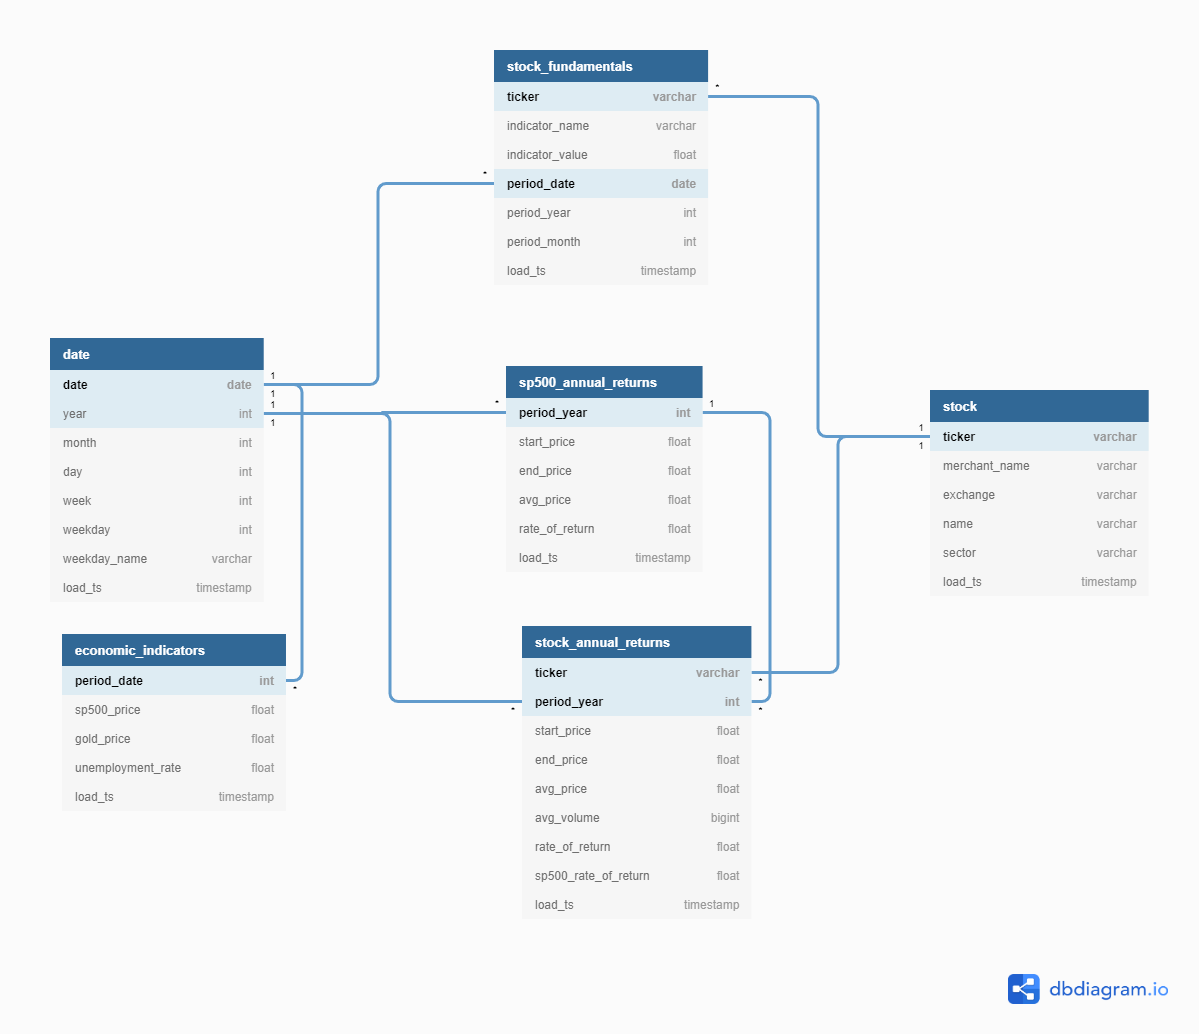

In [49]:
Image(filename='stocks.png') 

## Project Architecture

The overall project architecture for Stock Analytics is shown as below:
This process chart is developed using draw.io <https://www.draw.io/>


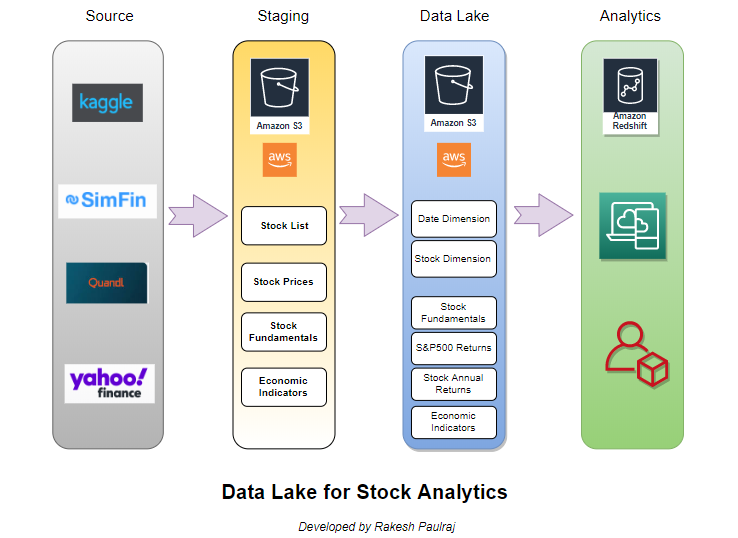

In [4]:
Image(filename='project_architecture.png') 

### Run Pipelines to Model the Data 
#### Create the data model
Build the data pipelines to create the data model.

### Create Dimension Table - Date

In [146]:
def create_date_table(start='1970-01-01', end='2050-12-31'):
    df = pd.DataFrame({"date": pd.date_range(start, end)})
    df["year"] = df.date.dt.year
    df["month"] = df.date.dt.day
    df["day"] = df.date.dt.day
    df["quarter"] = df.date.dt.quarter
    df["week"] = df.date.dt.weekofyear
    df["week_day"] = df.date.dt.weekday
    df["week_day_name"] = df.date.dt.weekday_name
    df["load_ts"] = pd.Timestamp.now()
    return df

df_date_pandas=create_date_table()
df_date = spark.createDataFrame(df_date_pandas)

In [147]:
# write `date` dimension data into parquet file
df_date.repartition(4).write.format("parquet").mode("overwrite").parquet(os.path.join(target_data_path, 'date'))

In [148]:
df_date = spark.read.format("parquet").parquet(os.path.join(target_data_path, 'date'))

In [149]:
df_date.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- year: long (nullable = true)
 |-- month: long (nullable = true)
 |-- day: long (nullable = true)
 |-- quarter: long (nullable = true)
 |-- week: long (nullable = true)
 |-- week_day: long (nullable = true)
 |-- week_day_name: string (nullable = true)
 |-- load_ts: timestamp (nullable = true)



In [53]:
check_if_table_empty(df_date, 'date')

** Running Data Validation rule - check_if_table_empty..
Table name = date
** Data Validation rule - check_if_table_empty - PASSED. Table contains 29585 rows


In [54]:
check_duplicates(df_date,'date',['date'])

** Running Data Validation rule - check_duplicates..
Table name = date
Column name = date
** Data Validation rule - check_duplicates - PASSED. Table contains 0 duplicate records


### Create Dimension Table - Stock

In [55]:
df_stg_stock.createOrReplaceTempView("staging_stock_view")
df_stock=spark.sql("""
select ticker, name, industry, sector, exchange, current_timestamp as load_ts
from staging_stock_view
""")

In [56]:
# write `stock` dimension data into parquet file
df_stock.repartition(4).write.format("parquet").mode("overwrite").parquet(os.path.join(target_data_path, 'stock'))

In [135]:
df_stock = spark.read.format("parquet").parquet(os.path.join(target_data_path, 'stock'))

In [136]:
df_stock.printSchema()

root
 |-- ticker: string (nullable = true)
 |-- name: string (nullable = true)
 |-- industry: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- exchange: string (nullable = true)
 |-- load_ts: timestamp (nullable = true)



In [57]:
check_if_table_empty(df_stock, 'stock')

** Running Data Validation rule - check_if_table_empty..
Table name = stock
** Data Validation rule - check_if_table_empty - PASSED. Table contains 6460 rows


In [58]:
check_duplicates(df_stock, 'stock', ['ticker'])

** Running Data Validation rule - check_duplicates..
Table name = stock
Column name = ticker
** Data Validation rule - check_duplicates - PASSED. Table contains 0 duplicate records


### Create Fact Table - sp500_annual_returns

In [59]:
df_stg_econind.createOrReplaceTempView("staging_economic_indicators_view")
df_sp500_annual_returns=spark.sql("""
select 
      period_year
    , round(start_price, 2) as start_price
    , round(end_price, 2) as end_price
    , round(avg_price, 2) as avg_price
    , round((end_price - start_price) * 100 / start_price, 2) as rate_of_return
    , current_timestamp as load_ts
from
(
    select 
      period_date
    , year(period_date) as period_year
    , avg(sp500_price) over(partition by date_trunc('year', period_date)) avg_price
    , row_number() over(partition by date_trunc('year', period_date) order by period_date desc) desc_rownum
    , first_value(sp500_price) over(partition by date_trunc('year', period_date) order by period_date) as start_price
    , last_value(sp500_price) over(partition by date_trunc('year', period_date) order by period_date) as end_price
    from staging_economic_indicators_view
) a where desc_rownum = 1
""")

In [60]:
%%timeit
# write `sp500_annual_returns` fact table data into parquet file
df_sp500_annual_returns.repartition(4).write.format("parquet").mode("overwrite").parquet(os.path.join(target_data_path, 'sp500_annual_returns'))

8.23 s ± 1.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
%%timeit
df_sp500_annual_returns = spark.read.format("parquet").parquet(os.path.join(target_data_path, 'sp500_annual_returns'))

84.7 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [62]:
df_sp500_annual_returns.printSchema()

root
 |-- period_year: integer (nullable = true)
 |-- start_price: double (nullable = true)
 |-- end_price: double (nullable = true)
 |-- avg_price: double (nullable = true)
 |-- rate_of_return: double (nullable = true)
 |-- load_ts: timestamp (nullable = false)



In [63]:
check_if_table_empty(df_sp500_annual_returns, 'sp500_annual_returns')

** Running Data Validation rule - check_if_table_empty..
Table name = sp500_annual_returns
** Data Validation rule - check_if_table_empty - PASSED. Table contains 50 rows


In [64]:
df_sp500_annual_returns.show(2)

+-----------+-----------+---------+---------+--------------+--------------------+
|period_year|start_price|end_price|avg_price|rate_of_return|             load_ts|
+-----------+-----------+---------+---------+--------------+--------------------+
|       2003|      855.7|  1111.92|   967.93|         29.94|2019-10-11 07:48:...|
|       1970|      85.02|    92.15|    83.45|          8.39|2019-10-11 07:48:...|
+-----------+-----------+---------+---------+--------------+--------------------+
only showing top 2 rows



### Create Fact Table - Stock_Annual_Returns

In [65]:
 # Staging table for Stock Prices 
df_stg_stockprice.createOrReplaceTempView("staging_stock_price_view")   

df_stock_annual_returns_first_day=spark.sql("""
        select ticker
        , period_date
        , year(period_date) as period_year
        , close
        from staging_stock_price_view a 
        where period_date in (select min(period_date) from staging_stock_price_view group by year(period_date))
""")

df_stock_annual_returns_last_day=spark.sql("""
        select ticker
        , period_date
        , year(period_date) as period_year
        , close
        from staging_stock_price_view a 
        where period_date in (select max(period_date) from staging_stock_price_view group by year(period_date))
""")


In [66]:
df_stock_annual_returns_first_day.write.format("parquet").mode("overwrite").parquet(os.path.join(target_data_path, 'stock_annual_returns_first_day'))

In [67]:
df_stock_annual_returns_last_day.write.format("parquet").mode("overwrite").parquet(os.path.join(target_data_path, 'stock_annual_returns_last_day'))

In [68]:
df_stock_annual_returns_first_day = spark.read.format("parquet").parquet(os.path.join(target_data_path, 'stock_annual_returns_first_day'))

In [69]:
df_stock_annual_returns_last_day = spark.read.format("parquet").parquet(os.path.join(target_data_path, 'stock_annual_returns_last_day'))

In [70]:
df_stock_annual_returns_first_day.createOrReplaceTempView("stock_annual_returns_first_day_view")  
df_stock_annual_returns_last_day.createOrReplaceTempView("stock_annual_returns_last_day_view")  
df_sp500_annual_returns.createOrReplaceTempView("sp500_annual_returns_view")  

df_stock_annual_returns=spark.sql("""
    select f.ticker
    , f.period_year
    , round(f.close ,2) as start_price
    , round(l.close, 2) as end_price
    , round((l.close - f.close) * 100 / f.close, 2) as rate_of_return
    , sp.rate_of_return as sp500_rate_of_return
    , current_timestamp as load_ts
    from stock_annual_returns_first_day_view f
    inner join stock_annual_returns_last_day_view l 
    on f.ticker = l.ticker
    and f.period_year = l.period_year
    left join sp500_annual_returns_view sp
    on f.period_year = sp.period_year
""")

In [71]:
%%timeit
# write `stock_returns` fact table data into parquet file
df_stock_annual_returns.write.format("parquet").mode("overwrite").parquet(os.path.join(target_data_path, 'stock_annual_returns'))

6.69 s ± 605 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [72]:
%%timeit
df_stock_annual_returns = spark.read.format("parquet").parquet(os.path.join(target_data_path, 'stock_annual_returns'))

65.9 ms ± 7.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [73]:
df_stock_annual_returns.printSchema()

root
 |-- ticker: string (nullable = true)
 |-- period_year: integer (nullable = true)
 |-- start_price: double (nullable = true)
 |-- end_price: double (nullable = true)
 |-- rate_of_return: double (nullable = true)
 |-- sp500_rate_of_return: double (nullable = true)
 |-- load_ts: timestamp (nullable = false)



In [74]:
check_if_table_empty(df_stock_annual_returns, 'stock_annual_returns')

** Running Data Validation rule - check_if_table_empty..
Table name = stock_annual_returns
** Data Validation rule - check_if_table_empty - PASSED. Table contains 81643 rows


In [75]:
df_stock_annual_returns \
.filter(df_stock_annual_returns.ticker == 'MSFT') \
.filter(df_stock_annual_returns.period_year >= 2010) \
.orderBy(df_stock_annual_returns.period_year) \
.show(10)

+------+-----------+-----------+---------+--------------+--------------------+--------------------+
|ticker|period_year|start_price|end_price|rate_of_return|sp500_rate_of_return|             load_ts|
+------+-----------+-----------+---------+--------------+--------------------+--------------------+
|  MSFT|       2010|      30.95|    27.91|         -9.82|               17.11|2019-10-11 07:52:...|
|  MSFT|       2011|      27.98|    25.96|         -7.22|               -2.22|2019-10-11 07:52:...|
|  MSFT|       2012|      26.77|    26.71|         -0.22|                8.67|2019-10-11 07:52:...|
|  MSFT|       2013|      27.62|    37.41|         35.45|               23.38|2019-10-11 07:52:...|
|  MSFT|       2014|      37.16|    46.45|          25.0|                15.5|2019-10-11 07:52:...|
|  MSFT|       2015|      46.76|    55.48|         18.65|                2.45|2019-10-11 07:52:...|
|  MSFT|       2016|       54.8|    62.14|         13.39|               15.39|2019-10-11 07:52:...|


### Create Fact Table - Stock_Fundamentals

In [76]:
df_stg_stockfund.createOrReplaceTempView("staging_stock_fundamentals_view")
df_stock_fundamentals=spark.sql("""
    select ticker
    , period_date
    , year(period_date) as period_year
    , quarter(period_date) as period_quarter
    , max(case when indicator_name = 'Accounts Payable' then indicator_value else null end) as accounts_payable
    , max(case when indicator_name = 'Net Profit' then indicator_value else null end) as net_profit
    , max(case when indicator_name = 'Revenues' then indicator_value else null end) as revenues
    , max(case when indicator_name = 'Dividends' then indicator_value else null end) as dividends
    , max(case when indicator_name = 'EBITDA' then indicator_value else null end) as EBITDA
    , max(case when indicator_name = 'Total Assets' then indicator_value else null end) as total_assets
    , max(case when indicator_name = 'Total Liabilities' then indicator_value else null end) as total_liabilities
    from staging_stock_fundamentals_view
    where indicator_name in ('Accounts Payable','Net Profit','Revenues','EBITDA','Total Assets','Total Liabilities')
    group by ticker, period_date
    order by ticker, period_date
""")

In [77]:
%%timeit
df_stock_fundamentals.repartition(4).write.format('parquet').mode('overwrite').parquet(os.path.join(target_data_path, 'stock_fundamentals'))

15.3 s ± 1.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
%%timeit
df_stock_fundamentals = spark.read.format('parquet').parquet(os.path.join(target_data_path, 'stock_fundamentals'))

55.6 ms ± 4.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
df_stock_fundamentals.printSchema()

root
 |-- ticker: string (nullable = true)
 |-- period_date: string (nullable = true)
 |-- period_year: integer (nullable = true)
 |-- period_quarter: integer (nullable = true)
 |-- accounts_payable: string (nullable = true)
 |-- net_profit: string (nullable = true)
 |-- revenues: string (nullable = true)
 |-- dividends: string (nullable = true)
 |-- EBITDA: string (nullable = true)
 |-- total_assets: string (nullable = true)
 |-- total_liabilities: string (nullable = true)



In [80]:
check_if_table_empty(df_stock_fundamentals, 'stock_fundamentals')

** Running Data Validation rule - check_if_table_empty..
Table name = stock_fundamentals
** Data Validation rule - check_if_table_empty - PASSED. Table contains 65177 rows


In [81]:
check_duplicates(df_stock_fundamentals, 'stock_fundamentals', ['ticker','period_date'])

** Running Data Validation rule - check_duplicates..
Table name = stock_fundamentals
Column name = ticker, period_date
** Data Validation rule - check_duplicates - PASSED. Table contains 0 duplicate records


### Create Fact Table - Economic_indicators

In [82]:
df_stg_econind.createOrReplaceTempView("staging_economic_indicators_view")
df_economic_indicators=spark.sql("""
    select cast(period_date as date) as period_date
    , year(period_date) as period_year
    , quarter(period_date) as period_quarter
    , sp500_price
    , gold_price
    , unemp_rate
    , current_timestamp as load_ts
    from staging_economic_indicators_view
""")

In [83]:
df_economic_indicators.repartition(4).write.format('parquet').mode('overwrite').parquet(os.path.join(target_data_path, 'economic_indicators'))

In [84]:
df_economic_indicators = spark.read.format('parquet').parquet(os.path.join(target_data_path, 'economic_indicators'))

In [85]:
df_economic_indicators.printSchema()

root
 |-- period_date: date (nullable = true)
 |-- period_year: integer (nullable = true)
 |-- period_quarter: integer (nullable = true)
 |-- sp500_price: double (nullable = true)
 |-- gold_price: double (nullable = true)
 |-- unemp_rate: double (nullable = true)
 |-- load_ts: timestamp (nullable = true)



In [86]:
check_if_table_empty(df_economic_indicators, 'economic_indicators')

** Running Data Validation rule - check_if_table_empty..
Table name = economic_indicators
** Data Validation rule - check_if_table_empty - PASSED. Table contains 597 rows


In [87]:
check_if_less_than_zero(df_economic_indicators, 'economic_indicators', 'unemp_rate')

** Running Data Validation rule - check_if_less_than_zero..
Table name = economic_indicators
Column name = unemp_rate
** Completed Data Validation rule - check_if_less_than_zero - PASSED. No values found to be less than zero for column unemp_rate.


### Data Quality Checks
The following Data Quality checks are performed:

 * Ensure target table count is not zero
 * Check for Duplicates on key fields
 * Unemployment rate in Economic Indicators table should not be negative.

 
#### Run Quality Checks
The above mentioned Data Quality checks are done in all of the previous steps as soon as the table is loaded. Please refer to the end of each Data Loading section to see the status of Data Quality checks.


### Data dictionary 


#### Date
Column Name | Description
----------- | -------------------------------------------------------------------
date | date value of each day ranging from 1970 till 2019
year | correponding year of each date
month | correponding month of each date
day | correponding numerical day value of each date
quarter | correponding quarter of each date
week | correponding week number of each date
week_day | correponding weekday numeric value of each date. Has values 0 to 6 where 0 represents Monday, 1 -  Tuesday, 2 - Wednesday, 3 - Thursday, 4 - Friday, 5 - Saturday, 6 - Sunday
week_day_name | Corresponding Weekday name of each date. Has values Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday
load_ts | Processing time indicating the time at which the data is loaded in this table.



#### Stock
Column Name | Description
----------- | -------------------------------------------------------------------
ticker|A ticker symbol is an arrangement of characters — usually letters — representing particular securities listed on an exchange or otherwise traded publicly which the investors and traders use to transact orders. 
name | 
industry | Industry is a narrow category used to classify and group stocks which performs similar type of business. Each market sector will have a group of Industries underneath and each industry will have a group of stocks
sector | The term market sector is used in economics and finance to describe a part of the economy. Analysts divide the stock market itself into market sectors so that shares of companies that are in direct competition are listed alongside each other
exchange | A stock exchange, securities exchange or bourse, is a facility where stock brokers and traders can buy and sell securities, such as shares of stock and bonds and other financial instruments.
load_ts | Processing time indicating the time at which the data is loaded in this table.



##### Stock_Price
Column Name | Description
----------- | -------------------------------------------------------------------
ticker|A ticker symbol is an arrangement of characters — usually letters — representing particular securities listed on an exchange or otherwise traded publicly which the investors and traders use to transact orders. 
open | The opening price is the price at which a security first trades when an exchange opens for the day. 
close | Closing price is the price of the final trade before the close of the trading session. 
adj_close | The adjusted closing price shows the stock's value after posting a dividend. 
low | Low price is the lowest price of the security for the given time period. 
high | High price is the highest price of the security for the given time period. 
volume | Trading volume, is the amount (total number) of a security (or a given set of securities, or an entire market) that was traded during a given period of time.
period_date | Event Date or the period on which this event has recorded.
period_year | Corresponding Year value of the Event Date or the period on which this event has recorded.
period_month | Corresponding MOnth value of the Event Date or the period on which this event has recorded.
load_ts | Processing time indicating the time at which the data is loaded in this table.


##### Stock_Fundamentals
Column Name | Description
----------- | -------------------------------------------------------------------
ticker|A ticker symbol is an arrangement of characters—usually letters—representing particular securities listed on an exchange or otherwise traded publicly which the investors and traders use to transact orders. 
period_date | Event Date or the period on which this event has recorded.
period_year | Corresponding Year value of the Event Date or the period on which this event has recorded.
period_quarter | Corresponding Quarter value of the Event Date or the period on which this event has recorded.
accounts_payable| Accounts Payable
net_profit| Net Profit for the given time period
revenues| Total revenues for the given time period
dividends| Dividends paid for the given time period
EBITDA| Earnings Before Tax, Depreciation & Assets
total_assets| Total Assets value for the given time period
total_liabilities| Total Liabilities for the given time period
load_ts | Processing time indicating the time at which the data is loaded in this table.


##### Economic Indicators
Column Name | Description
----------- | -------------------------------------------------------------------
period_date | Event Date or the period on which this event has recorded.
period_year | Corresponding Year value of the Event Date or the period on which this event has recorded.
period_quarter | Corresponding Quarter value of the Event Date or the period on which this event has recorded.
sp500_returns | S&P500 Index value for the given time period
gold_price | Godl price from London Bullion Market Association (LBMA) for the given time period
unemployment_rate | The unemployment rate represents the number of unemployed as a percentage of the labor force. Labor force data are restricted to people 16 years of age and older, who currently reside in 1 of the 50 states or the District of Columbia, who do not reside in institutions (e.g., penal and mental facilities, homes for the aged), and who are not on active duty in the Armed Forces. 
load_ts | Processing time indicating the time at which the data is loaded in this table.


#####  SP500_annual_summary
Column Name | Description
----------- | -------------------------------------------------------------------
period_year | Corresponding Year value of the Event Date or the period on which this event has recorded.
start_price | Starting price of the S&P 500 Index for the given time period
end_price | Ending price of the S&P 500 Index for the given time period
avg_price | Average price of the S&P 500 Index for the given time period
rate_of_return | Rate of Return for S&P500 Index for the given time period. A rate of return (RoR) is the net gain or loss on an investment over a specified time period, expressed as a percentage of the investment's initial cost. 
load_ts | Processing time indicating the time at which the data is loaded in this table.


#####  Stock_annual_summary
Column Name | Description
----------- | -------------------------------------------------------------------
ticker|A ticker symbol is an arrangement of characters—usually letters—representing particular securities listed on an exchange or otherwise traded publicly which the investors and traders use to transact orders. 
period_year | Corresponding Year value of the Event Date or the period on which this event has recorded.
start_price | Starting price of the Stock for the given time period
end_price | Ending price of the Stock for the given time period
avg_price | Average price of the Stock for the given time period
avg_volume | Average volume traded for the Stock for the given time period
rate_of_return | A rate of return (RoR) is the net gain or loss on an investment over a specified time period, expressed as a percentage of the investment's initial cost. 
sp500_rate_of_return | Rate of Return for S&P500 Index for the given time period. A rate of return (RoR) is the net gain or loss on an investment over a specified time period, expressed as a percentage of the investment's initial cost. 
load_ts | Processing time indicating the time at which the data is loaded in this table.



### Tools and Environment

Tool & Environment | Name | Rationale behind using this tool/platform
------------------ | ------------ | ---------------
Processing framework | Apache Spark | This project is developed using Apache Spark to make use of distributed computing and In-memory processing. 
Data Storage layer | Amazon S3 | Amazon S3 provides easy-to-use management features so you can organize your data and configure finely-tuned access controls to meet your specific business, organizational, and compliance requirements. Amazon S3 is designed for 99.999999999% (11 9's) of durability, and stores data for millions of applications for companies all around the world
Cluster Computing Engine/Service | Amazon EMR | Amazon Elastic MapReduce (EMR) is an Amazon Web Services (AWS) tool for big data processing and analysis. Amazon EMR offers the expandable low-configuration service as an easier alternative to running in-house cluster computing
Development Tools | Python, Ipython, Jupyter notebook | Python has vey rich packages to work with Spark and Data processing needs. In this project, Pyspark package is used for Spark SQL framework. Jupyter Notebook helps to do step by step execution of the program during development stages and provides a neat interface to run the code as well to record the observations in presentable format.
ER Diagram        | dbdiagram.io | A simple and great interface to generate ER diagram
Process flow charts | draw.io | A simple and great interface to draw various process flow diagrams. Has many inbuilt templates to choose from.
Code Repository | Github | GitHub is a Git repository hosting service, but it adds many of its own features. While Git is a command line tool, GitHub provides a Web-based graphical interface. It also provides access control and several collaboration features, such as a wikis and basic task management tools for every project

![alt text](datalake.png "Data Lake")

## Stock Analytics

One of the main goals of this project is to make the data available for Analysts so that they can various Analytics and derive valuable insights.
There are various analytics that can be run on this Stock Price data.

The following Analysis are performed in this project using visualizations: 
* Comparison of the Total Stock Maket (S&P500 value) with Gold Prices during the same period.
* Most profitable Stocks (Top Gainers) for year 2017
* Range of values for Unemployment rate.
* Number of Companies per each Sector


#### SP500 Index Vs Gold Price
  * Line chart mentioned below compares S&P500 Index value with Gold Price for the time period 1970 to 2019
  
  * An important observation here is to note how the Gold Price increases when the Stock Market returns are low.
  
  * Its very common in Investing world that Investors will redirect the funds from Stocks to Gold as a hedging tecnique and for the reason, we can see the Gold prices when the market is experiencing a pullback or recession.

  * In the below chart, you can see that during the 2007-2010 recession period, S&P500 Index value has dropped. At the same time, Gold Price has gone up.
  
  * Similarly, After 2013 once the recession fears are settled down, Stock Market was set to rebound. So Investors turned their money again from Gold into Stock Market due to which Gold Price went down for next few years.
  
  * Lastly, observe the Spike in the Gold Price since last year. This is due to the fact that the Stock Market is fully saturated and its highlu expected a recession to follow in coming years. So Investors again preparing themselves to route the money to Gold.
  


In [126]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [127]:
df_econind_plot=df_economic_indicators.orderBy('period_date').toPandas()

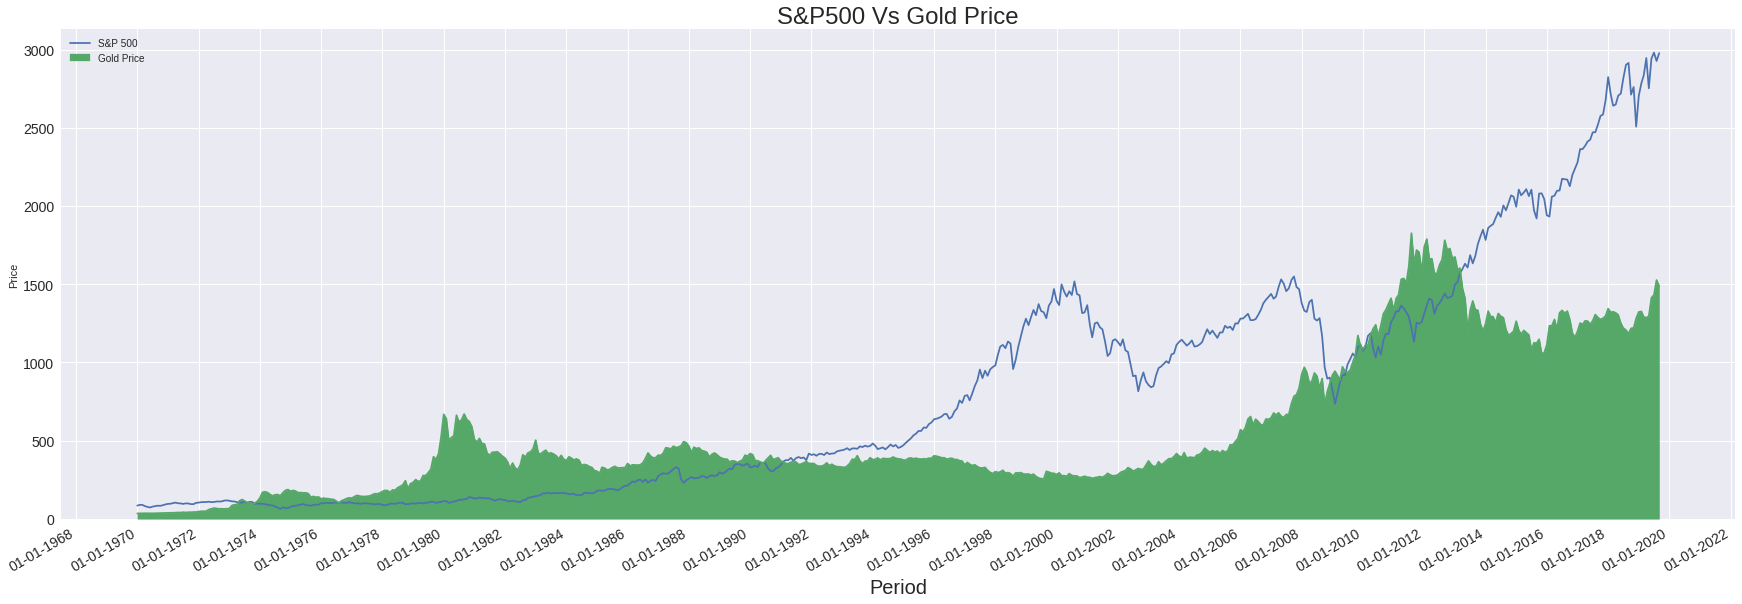

In [133]:
fig=plt.figure(figsize=(30,10))

ax = plt.gca()
ax.set_title('S&P500 Vs Gold Price', fontsize=24)
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

df_econind_plot.plot(kind='line', x='period_date', y='sp500_price', label="S&P 500", legend=True, ax=ax, fontsize=14)
df_econind_plot.plot(kind='area', x='period_date', y='gold_price', label="Gold Price", legend=True, ax=ax)
plt.xlabel('Period' , fontsize=20)
plt.ylabel('Price')
#plt.ylim(-.5, 1.5)
plt.gcf().autofmt_xdate() 
plt.style.use('ggplot')

plt.show()

### Most Profitable Stocks on Year 2017



To find out the Most profitable stocks for year 2017, following steps are done:
  * Use the stock_annual_returns fact table
  * Filter data for period_year = 2017
  * Since a lot of Small caps or Penny stocks (Espcially Pharma companies) can have very high volatility, an assumption is made to consider stocks whose Start price is over $20. So filter data whose Start Price > 20
  * Filter data whose rate of return is greater than SP500 rate of returns.
  * Finally fetch only Top 20 Stocks

In [129]:
df_stock_annual_returns_plot=df_stock_annual_returns \
.filter(df_stock_annual_returns['period_year']==2017) \
.filter(df_stock_annual_returns['start_price'] > 20) \
.filter(df_stock_annual_returns['rate_of_return'] > df_stock_annual_returns['sp500_rate_of_return']) \
.orderBy(df_stock_annual_returns['rate_of_return'], ascending=False) \
.limit(20) \
.toPandas()

Using the above data, a bar chart is done to show the Top 20 profitable stocks of year 2017.
  * For year 2017, SP500 Rate of return is 17.32%
  * For the Top 20 profitable stocks, the rate of return ranges from 246% to 133%
  * Some of the big names such as SHOP, ANET are also exists in the Top 20
  * Shopify (SHOP) is a well known growth stock. Mentioned below is an article about Shopify's (SHOP) stellar growth on 2017.

    https://www.fool.com/investing/2018/01/22/why-2017-was-a-year-to-remember-for-shopify-inc.aspx

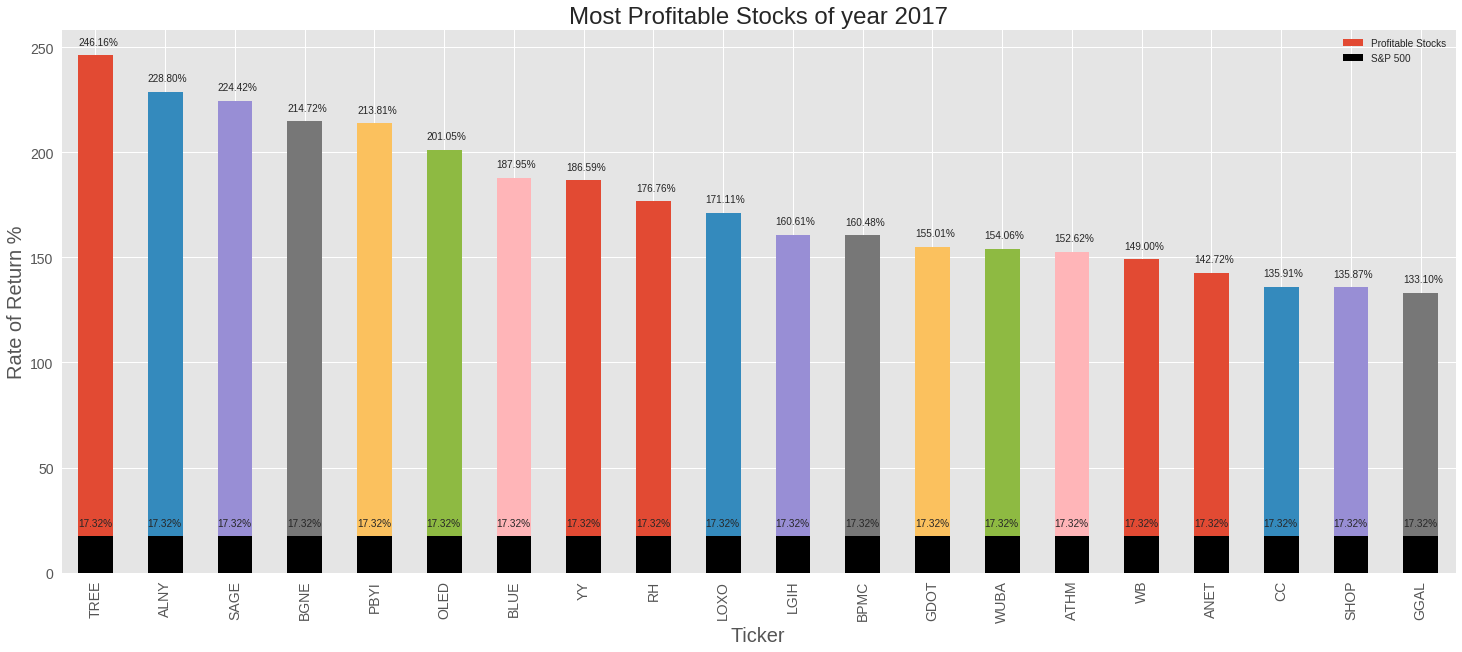

In [130]:
fig=plt.figure(figsize=(25,10))
ax = plt.gca()
ax.set_title('Most Profitable Stocks of year 2017', fontsize=24)

df_stock_annual_returns_plot.plot(kind='bar', x='ticker', y='rate_of_return', label="Profitable Stocks", legend=True, ax=ax, fontsize=14,  stacked=True)
df_stock_annual_returns_plot.plot(kind='bar', x='ticker', y='sp500_rate_of_return', label="S&P 500", legend=True, color='black', ax=ax, fontsize=14, stacked=True)

labels=df_stock_annual_returns_plot['rate_of_return']
[ax.text(i-.25, labels[i]+5, '{:.2f}%'.format(v)) for i, v in enumerate(labels)];
labels=df_stock_annual_returns_plot['sp500_rate_of_return']
[ax.text(i-.25, labels[i]+5, '{:.2f}%'.format(v)) for i, v in enumerate(labels)];

plt.xlabel('Ticker', fontsize=20)
plt.ylabel('Rate of Return %', fontsize=20)
plt.style.use('seaborn')
plt.show()

#### Unemployment Rate

* Below Box plot and Density Plot shows that most of the time, Unemployment Rate stays between 5% and 7%
* The Area chart shows that the Unemployment remained highest from year 2008 till 2011 due to the Economic recession at that time.
* The Area chart shows that the Unemployment is at one of its lowest levels now since the US economy is adding more jobs at recent times.
  
  Mentioned below is an article published recently mentioning that the US unemployment falls to 50 year low.
  
  https://www.whitehouse.gov/articles/u-s-unemployment-rate-falls-50-year-low/

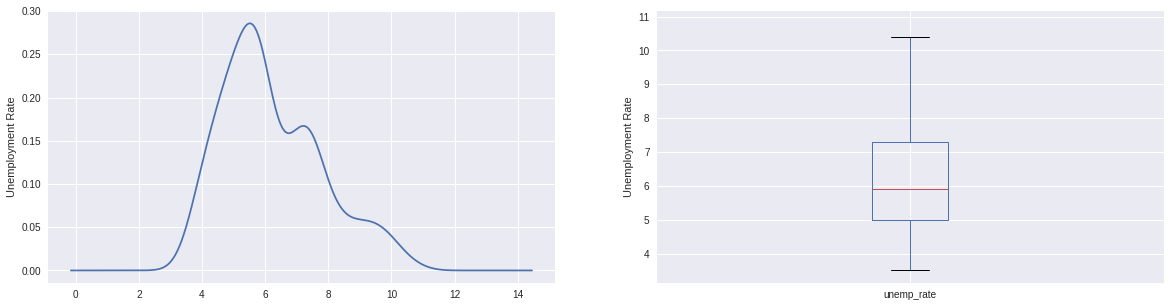

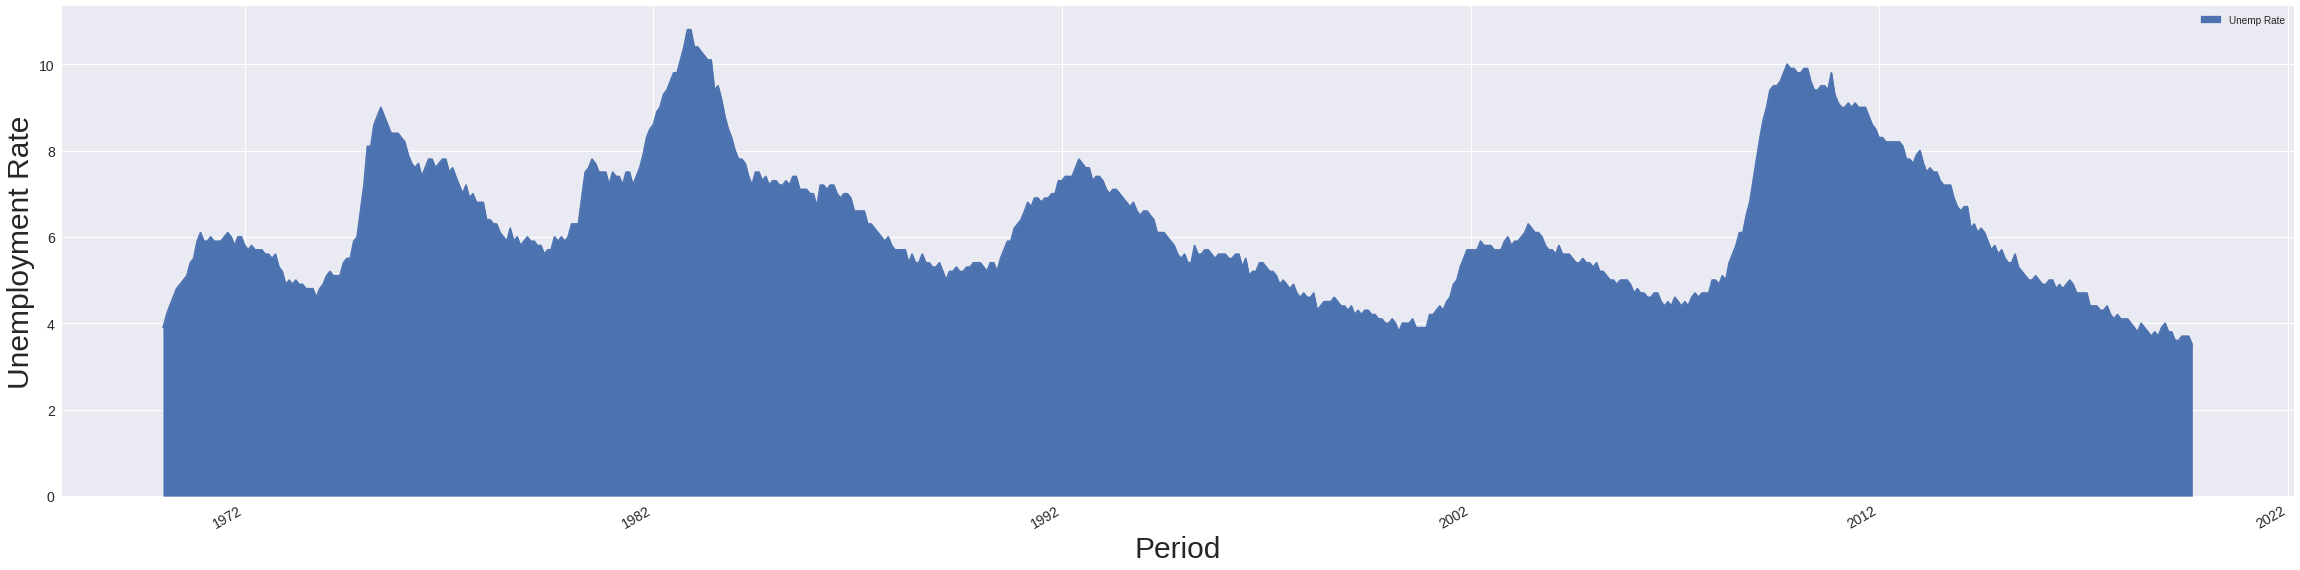

In [131]:
df_unemprate_plot=df_economic_indicators.toPandas().sort_values('period_date')

fig=plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
df_unemprate_plot['unemp_rate'].plot.kde()
plt.ylabel('Unemployment Rate')

plt.subplot(1,2,2)
df_unemprate_plot['unemp_rate'].plot.box()
plt.ylabel('Unemployment Rate')

fig=plt.figure(figsize=(40,10))
ax = plt.gca()
df_unemprate_plot.plot(kind='area', x='period_date', y='unemp_rate', label="Unemp Rate", legend=True, ax=ax, fontsize=14)

plt.xlabel('Period', fontsize=30)
plt.ylabel('Unemployment Rate', fontsize=30)
plt.gcf().autofmt_xdate() 
plt.style.use('seaborn')

#### Companies by Sector

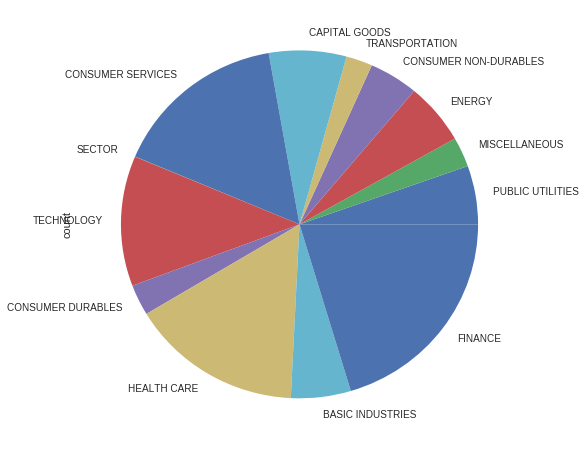

In [132]:
df_stock_plot=df_stock.filter(df_stock['Sector'] != 'N/A').groupBy('Sector').count().toPandas()
df_stock_plot.plot(kind="pie", y='count', labels=df_stock_plot['Sector'], figsize=(8,8), legend=False)

### Scenarios & Solutions for future considerations
 
 
#### 1. Scenario - Data increased by 100x:

For instance, consider the Spark is running on Amazon EMR using EC2 clusters. If the Clusters are of type m5.xlarge, then it provides 4 vCPUs, 16 GB of RAM, Network bandwidth of 10 Gbps. 

In the scenario of our data increasing by 100x, we can handle the load by following options:

1. Increase the number of instances by 100x
2. Upgrade to More powerful instance type
  *  For eg: In Amazon EMR, Choosing an Instance Type of c5n.18xlarge provides provides 72 vCPUs, 192 GB of RAM and 100Gbps of Network speed.
3. Launch the Instances in Auto Scaling Mode (If your cloud provider has that option). Both Google (GCP) and Amazon (AWS) has Auto scaling mode.
  
  
#### 2. Scenario - data populates a dashboard that must be updated on a daily basis by 7am every day:

This can be achieved by automating the Data pipeline and schedule the run at the required time and frequency using Apache Airflow.

Airflow is a platform to programmatically author, schedule and monitor workflows.

Use airflow to author workflows as directed acyclic graphs (DAGs) of tasks. The airflow scheduler executes your tasks on an array of workers while following the specified dependencies. Rich command line utilities make performing complex surgeries on DAGs a snap. The rich user interface makes it easy to visualize pipelines running in production, monitor progress, and troubleshoot issues when needed.

https://airflow.apache.org/


#### 3. Scenario - database needed to be accessed by 100+ people:
In this project, data is loaded into Data Lake which is stored as Parquet files. The data can be retrieved from Parquet files programatically or by using tools such as Presto.

But if the database needs to be accessed by 100+ people with corresponding access prileges assigned to the end users, then one of the options is to load the final Dimensions and Fact tables into Amazon Redshift. In Redshift, we can configure the Clusters based on workload and the number of users consuming the data. Other reporting tools such as Tableau can connect to Redshift and pull the data for Dashboards.

When we expose the data to multiple users, it is important to manage the access privileges regarding which data users can access and which they should not. These privileges can be setg by creating different IAM roles in AWS and assign such roles to the end users.


